In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import random
import pickle
drive.mount('/content/drive')
file_dir = "/content/drive/My Drive/names.npz"
zip_data = np.load(file_dir, allow_pickle=True)
label_dic = zip_data['label_dic'].item()
index_dic = zip_data['idx_dic'].item()
X = zip_data['x']
Y = zip_data['y']


Mounted at /content/drive


In [ ]:
def cut(x):
    for i, k in enumerate(x):
        if k == 26:
            return x[:i]
    return x

def index2Onehot(x):
    one_hot = torch.zeros((len(x), 27), dtype=torch.float32)
    for i in range(len(x)):
        one_hot[i][x[i]] = 1.0
    return one_hot

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.Wreset = nn.Linear(input_size + hidden_size, hidden_size)
        self.r_sig = nn.Sigmoid()
        self.Wgate = nn.Linear(input_size + hidden_size, hidden_size)
        self.g_sig = nn.Sigmoid()
        self.Wmain = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        r = self.r_sig(self.Wreset(combined))
        g = self.g_sig(self.Wgate(combined))
        hidden = (1.0 - g) * h + g * self.tanh(self.Wmain(torch.cat((x, r * h), dim=1))) 
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)




learning_rate = 0.000005
n_hidden = 128
rnn = GRU(len(index_dic), n_hidden)
Wout = nn.Linear(n_hidden, len(label_dic))
solver = optim.Adam(list(rnn.parameters()) + list(Wout.parameters()) , learning_rate)

In [ ]:
LOSS = []
for _ in range(50):
    LOSS_AVG = 0.0
    for nb_batch in range(10000):
        solver.zero_grad()
        data_index = random.randint(0, len(X) - 1)
        x = cut(X[data_index])
        y = torch.LongTensor([Y[data_index]])
        x = index2Onehot(x).unsqueeze(1)
        h = rnn.initHidden()
        for c in x:
            h = rnn(c, h)
        loss = F.cross_entropy(Wout(h), y)
        loss.backward()
        solver.step()
        LOSS_AVG += loss.item()
    LOSS.append(LOSS_AVG/10000)
    print(LOSS[-1])

2.338953101875633
1.7714777745455503
1.7657751948311924
1.748272775313258
1.6862693977966905
1.675343518768251
1.6416441442504526
1.634166139997542
1.5976516233228146
1.5482249634757639
1.5586765725523233
1.5269293113794178
1.5132762709645555
1.4926789885465055
1.4527268543692307
1.4504867309953087
1.4269173806855455
1.4088780532192904
1.3885045915607828
1.3920122014126741
1.3626884498510043
1.3748641417323844
1.3154190194854745
1.3352682693523588
1.3048364709859481
1.273043364491593
1.284202341177105
1.2678458415752043
1.247566565852496
1.2522942110972712
1.2415892422691686
1.232085894786514
1.2101468723064288
1.2105063887330587
1.2117966852081008
1.167469615905988
1.1771684767425643
1.1708159161901917
1.1656248611835267
1.1587991381741827
1.1267914911335422
1.1323509803072316
1.119522267336308
1.1232862381993736
1.1310113543853046
1.0947913295638632
1.123441936986451
1.0981649311677901
1.102229119870407
1.077189615956656


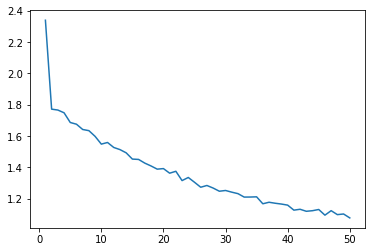

In [ ]:
plt.plot(np.arange(1, len(LOSS)+1), LOSS)
plt.show()


In [ ]:
with torch.no_grad():
    correct = 0
    for iter in range(10000):
        data_index = random.randint(0, len(X) - 1)
        x = cut(X[data_index])
        y = torch.LongTensor([Y[data_index]])
        x = index2Onehot(x).unsqueeze(1)
        h = rnn.initHidden()
        for c in x:
            h = rnn(c, h)
        o = Wout(h)
        if torch.argmax(o).item() == y.item():
            correct += 1
    print('accuracy : ', correct/10000)


accuracy :  0.6841


In [ ]:
with torch.no_grad():

    data_index = random.randint(0, len(X) - 1)
    x = cut(X[data_index])
    y = torch.LongTensor([Y[data_index]])
    x = index2Onehot(x).unsqueeze(1)
    h = rnn.initHidden()
    name = []
    for c in x:
        h = rnn(c, h)
        name.append(chr(torch.argmax(c).item() + ord('a')))
    o = Wout(h)
    print('name : ', ''.join(name))
    print('answ : ', label_dic[y.item()])
    prob = F.softmax(o, dim=-1).squeeze()
    prob, idx = torch.topk(prob, 3)
    for k in range(len(prob)):
        print(k + 1,':', label_dic[idx[k].item()], 'prob:',prob[k].item())


name :  handal
answ :  Arabic
1 : Arabic prob: 0.46576735377311707
2 : English prob: 0.2028008997440338
3 : Russian prob: 0.1846141219139099
